# Test Time Augmention

## Rotated MNIST at test

##### Dataset

In [1]:
import torch
import copy
import os
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from experiments.nns.bdl import SelectMNISTDataset


# Define the path to directory containing MNIST
mnist_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("uncertainty.ipynb")), "..","..","..","..","..","..","..", "/usr/data1/vision/data/"))


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST training dataset
# train_dataset = datasets.MNIST(root=mnist_directory, train=True, download=False, transform=transform)
train_dataset = SelectMNISTDataset(root=mnist_directory, train=True, numbers = [0,1,2,3,4,5,6,7,8,9], num_entries_per_digit=10, transform=transform)

## Creating rotated dataset

In [2]:
import torch
import copy
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from experiments.nns.bdl import CustomMNISTDataset

# Example usage:
selected_numbers = [1]
# Include rotation in the transformation
# transform = transforms.Compose([
#     transforms.RandomRotation(degrees=(-180, 180), fill=(0,)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# rotation_angles = [0, 15, 30, 45, 60, 75, 80, 95]
rotation_angles = []
for i in range(12):
    rotation_angles.append(i*5.5)
def get_rotated_mnist_dataset(degrees):
    rotate_transform = transforms.Compose([
            transforms.RandomRotation(degrees=(degrees, degrees), fill=(0,)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])
    rotated_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=rotate_transform)
    rotated_loader = DataLoader(rotated_dataset, batch_size=512, shuffle=False)
    return rotated_dataset, rotated_loader
rotated_datasets = []
rotated_loaders = []

for angle in rotation_angles:
    rotated_dataset, rotated_loader = get_rotated_mnist_dataset(angle)
    rotated_datasets.append(rotated_dataset)
    rotated_loaders.append(rotated_loader)


test_dataset = CustomMNISTDataset(root=mnist_directory, numbers=selected_numbers, train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## Training

In [3]:
import torch
from torch.utils.data import DataLoader
import push.bayes.ensemble
from experiments.nns.lenet.lenet import LeNet


# Create data loaders
batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
epochs = 50

ensemble = push.bayes.ensemble.train_deep_ensemble(
        train_loader,
        torch.nn.CrossEntropyLoss(),
        epochs,
        LeNet,
        num_devices=2,
        num_ensembles=100,
        cache_size=25
    )

100%|██████████| 50/50 [04:02<00:00,  4.85s/it, loss=tensor(0.1465)]


In [4]:
outputs = []
for loader in rotated_loaders:
    outputs.append(ensemble.posterior_pred(loader,f_reg=False, mode=["mode","logits","prob"]))

def get_mode(output, mode):
    return output[mode]

In [5]:
# Display rotated images
# num_images_to_display = 
idx_image_to_display = 4
imgs = []
lbls = []
for dataset in rotated_datasets:
    rotated_loader_small = DataLoader(dataset, batch_size=512, shuffle=False)
    for images, labels in rotated_loader_small:
        imgs.append(images[idx_image_to_display])
        lbls.append(labels[idx_image_to_display])
        break

In [9]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def offset_image(coord, i, ax, low_img, low_index, zoom):
    '''mnist_classification_mc_dropout.ipynb [1]'''
    img = imgs[i]
    im = OffsetImage(img.squeeze(), zoom=zoom)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (coord, low_img),
        xybox=(0.0, low_index),
        frameon=False,
        boxcoords="offset points",
    )
    ax.add_artist(ab)

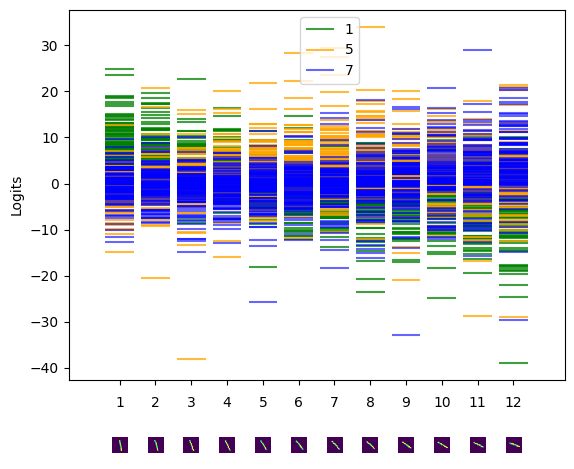

In [7]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1)
zoom = 0.4
# else:
#     plt.rcParams["font.size"] = 16
#     fig, ax = plt.subplots(1, figsize=(12, 6))
#     zoom = 1
index = np.arange(len(outputs))
for i, output in enumerate(outputs):
    ax.eventplot(
        get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(0)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="green",
        alpha=0.75,
    )
    ax.eventplot(
        get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(1)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="orange",
        alpha=0.75,
    )
    ax.eventplot(
        get_mode(output, "logits")[:,:,(1,3,7)][idx_image_to_display][:,(2)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="blue",
        alpha=0.6,
    )

ax.set_xticks(index)
ax.set_xticklabels(index + 1)
ax.tick_params(axis="x", which="major", pad=8)
ax.set_ylabel("Logits")
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l - 5, zoom)
ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
# sns.despine()
# savefig("mnist_softmax_input", tight_bbox=True, pad=1)
plt.show()

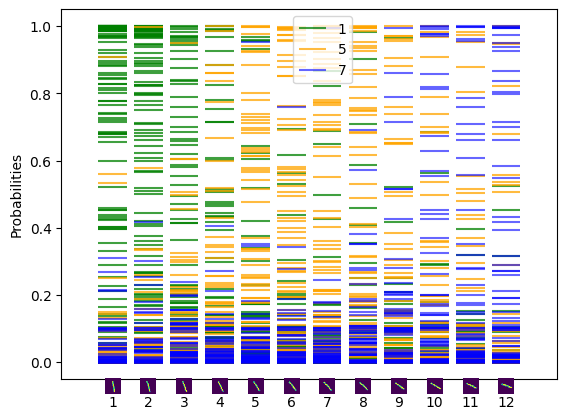

In [10]:
fig, ax = plt.subplots(1)
zoom = 0.4
# else:
#     plt.rcParams["font.size"] = 16
#     fig, ax = plt.subplots(1, figsize=(12, 6))
#     zoom = 1
index = np.arange(len(outputs))
for i, output in enumerate(outputs):
    '''mnist_classification_mc_dropout.ipynb [1]'''
    ax.eventplot(
        get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(0)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="green",
        alpha=0.75,
    )
    ax.eventplot(
        get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(1)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="orange",
        alpha=0.75,
    )
    ax.eventplot(
        get_mode(output, "prob")[:,:,(1,3,7)][idx_image_to_display][:,(2)],
        orientation="vertical",
        lineoffsets=i,
        linelengths=0.8,
        colors="blue",
        alpha=0.6,
    )

ax.set_xticks(index)
ax.set_xticklabels(index + 1)
ax.tick_params(axis="x", which="major", pad=8)
ax.set_ylabel("Probabilities")
l, h = ax.get_ylim()
for i in index:
    offset_image(i, i, ax, l, l - 5, zoom)
ax.legend(["1", "5", "7"], bbox_to_anchor=(0.6, 1.0))
# sns.despine()
# savefig("mnist_softmax_input", tight_bbox=True, pad=1)
plt.show()

[1] Kevin Murphy. Probabilistic Machine Learning Advanced Topics. Chapter 17. The MIT Press: Adaptive computation and machine learning series (2023). Cambridge, Massachusetts.